# Understanding the Adam Optimizer

This notebook explains how the **Adam (Adaptive Moment Estimation)** optimizer works in neural networks.

## What is Adam?

Adam is an optimization algorithm that combines the best properties of two other optimizers:
- **AdaGrad**: Adapts learning rates based on parameter importance
- **RMSProp**: Uses moving averages of squared gradients

Adam computes adaptive learning rates for each parameter by maintaining both first and second moment estimates of the gradients.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

## The Adam Algorithm

Adam maintains two moving averages for each parameter:

1. **First moment (mean)**: $m_t$ - exponentially decaying average of past gradients
2. **Second moment (uncentered variance)**: $v_t$ - exponentially decaying average of past squared gradients

### Algorithm Steps:

For each iteration $t$:

1. Compute gradient: $g_t = \nabla_\theta L(\theta_{t-1})$

2. Update biased first moment estimate:
   $$m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t$$

3. Update biased second moment estimate:
   $$v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2$$

4. Compute bias-corrected first moment:
   $$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$

5. Compute bias-corrected second moment:
   $$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$

6. Update parameters:
   $$\theta_t = \theta_{t-1} - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

### Hyperparameters:
- $\alpha$: Learning rate (default: 0.001)
- $\beta_1$: Exponential decay rate for first moment (default: 0.9)
- $\beta_2$: Exponential decay rate for second moment (default: 0.999)
- $\epsilon$: Small constant for numerical stability (default: 1e-8)

## Implementing Adam from Scratch

In [3]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None  # First moment
        self.v = None  # Second moment
        self.t = 0     # Time step
    
    def update(self, params, grads):
        """
        Update parameters using Adam optimization.
        
        Args:
            params: Current parameter values
            grads: Gradients of the loss with respect to parameters
        
        Returns:
            Updated parameters
        """
        # Initialize moments on first call
        if self.m is None:
            self.m = np.zeros_like(params)
            self.v = np.zeros_like(params)
        
        self.t += 1
        
        # Update biased first moment estimate
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        
        # Update biased second moment estimate
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grads ** 2)
        
        # Compute bias-corrected first moment
        m_hat = self.m / (1 - self.beta1 ** self.t)
        
        # Compute bias-corrected second moment
        v_hat = self.v / (1 - self.beta2 ** self.t)
        
        # Update parameters
        params = params - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        
        return params

print("Adam optimizer implemented successfully!")

Adam optimizer implemented successfully!


## Why Bias Correction?

The bias correction is crucial because $m$ and $v$ are initialized at zero. Without correction, they would be biased toward zero, especially during the initial time steps.

Let's visualize this effect:

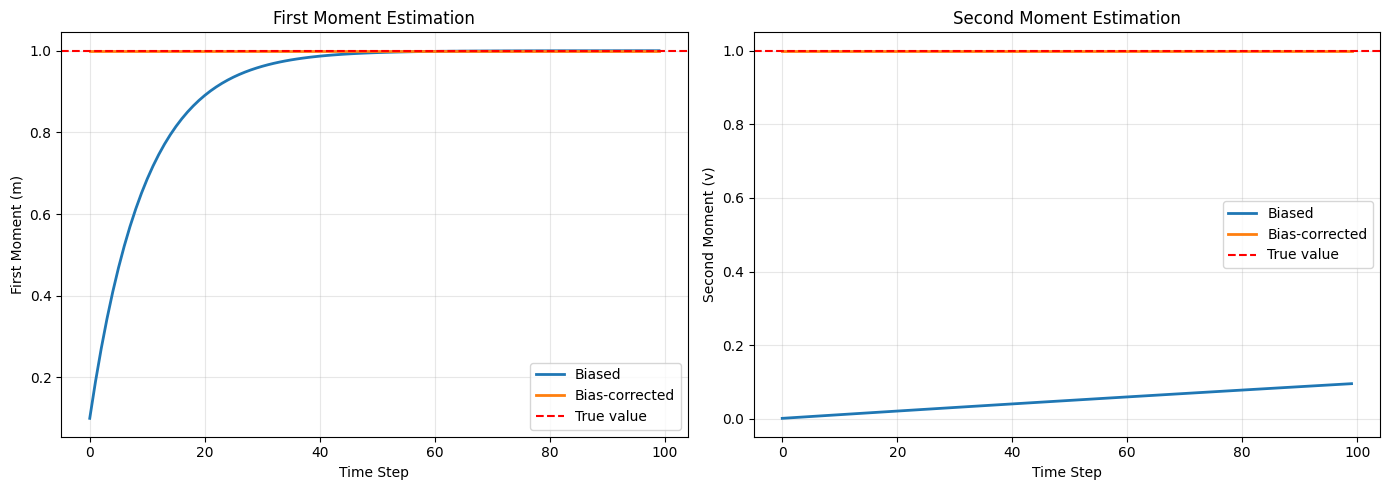

Without bias correction, the moments start at zero and slowly converge.
With bias correction, they quickly reach the true values!


In [4]:
# Simulate the effect of bias correction
beta1, beta2 = 0.9, 0.999
steps = 100

# Simulate constant gradient of 1.0
m_biased = []
m_corrected = []
v_biased = []
v_corrected = []

m, v = 0, 0
for t in range(1, steps + 1):
    m = beta1 * m + (1 - beta1) * 1.0
    v = beta2 * v + (1 - beta2) * 1.0
    
    m_biased.append(m)
    m_corrected.append(m / (1 - beta1 ** t))
    v_biased.append(v)
    v_corrected.append(v / (1 - beta2 ** t))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(m_biased, label='Biased', linewidth=2)
ax1.plot(m_corrected, label='Bias-corrected', linewidth=2)
ax1.axhline(y=1.0, color='r', linestyle='--', label='True value')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('First Moment (m)')
ax1.set_title('First Moment Estimation')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(v_biased, label='Biased', linewidth=2)
ax2.plot(v_corrected, label='Bias-corrected', linewidth=2)
ax2.axhline(y=1.0, color='r', linestyle='--', label='True value')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Second Moment (v)')
ax2.set_title('Second Moment Estimation')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Without bias correction, the moments start at zero and slowly converge.")
print("With bias correction, they quickly reach the true values!")

## Understanding Moment Decay Rates

The hyperparameters $\beta_1$ and $\beta_2$ control how much history is retained:
- Higher values = more history retained
- Lower values = more responsive to recent gradients

Let's visualize how different decay rates affect the moment estimates:

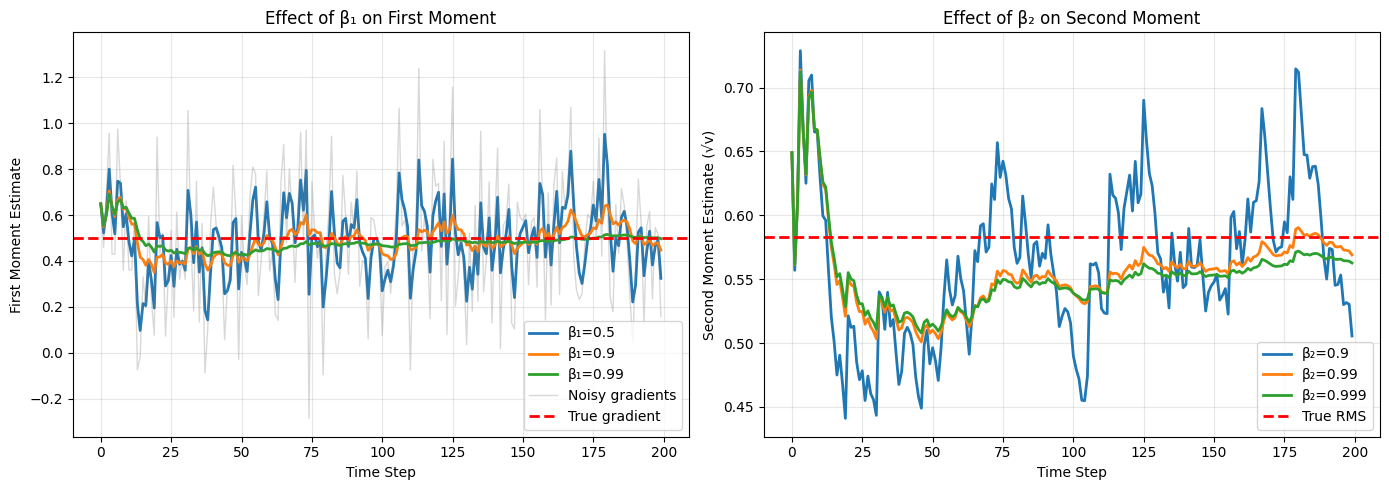

In [5]:
# Simulate gradient sequence with noise
np.random.seed(42)
steps = 200
true_gradient = 0.5
gradients = true_gradient + 0.3 * np.random.randn(steps)

# Test different beta1 values
beta1_values = [0.5, 0.9, 0.99]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# First moment with different beta1
for beta1 in beta1_values:
    m = 0
    m_history = []
    for t, grad in enumerate(gradients, 1):
        m = beta1 * m + (1 - beta1) * grad
        m_hat = m / (1 - beta1 ** t)
        m_history.append(m_hat)
    ax1.plot(m_history, label=f'β₁={beta1}', linewidth=2)

ax1.plot(gradients, 'gray', alpha=0.3, linewidth=1, label='Noisy gradients')
ax1.axhline(y=true_gradient, color='r', linestyle='--', linewidth=2, label='True gradient')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('First Moment Estimate')
ax1.set_title('Effect of β₁ on First Moment')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Second moment with different beta2
beta2_values = [0.9, 0.99, 0.999]
for beta2 in beta2_values:
    v = 0
    v_history = []
    for t, grad in enumerate(gradients, 1):
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        v_hat = v / (1 - beta2 ** t)
        v_history.append(np.sqrt(v_hat))
    ax2.plot(v_history, label=f'β₂={beta2}', linewidth=2)

ax2.axhline(y=np.sqrt(true_gradient**2 + 0.3**2), color='r', linestyle='--', 
           linewidth=2, label='True RMS')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Second Moment Estimate (√v)')
ax2.set_title('Effect of β₂ on Second Moment')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Adaptive Learning Rates

The key insight of Adam is that each parameter gets an adaptive learning rate based on:
- **First moment** ($m$): Provides momentum
- **Second moment** ($v$): Scales the learning rate inversely with gradient magnitude

The effective learning rate for parameter $i$ at time $t$ is:

$$\alpha_{\text{eff},i,t} = \frac{\alpha}{\sqrt{\hat{v}_{i,t}} + \epsilon}$$

Let's visualize how this works:

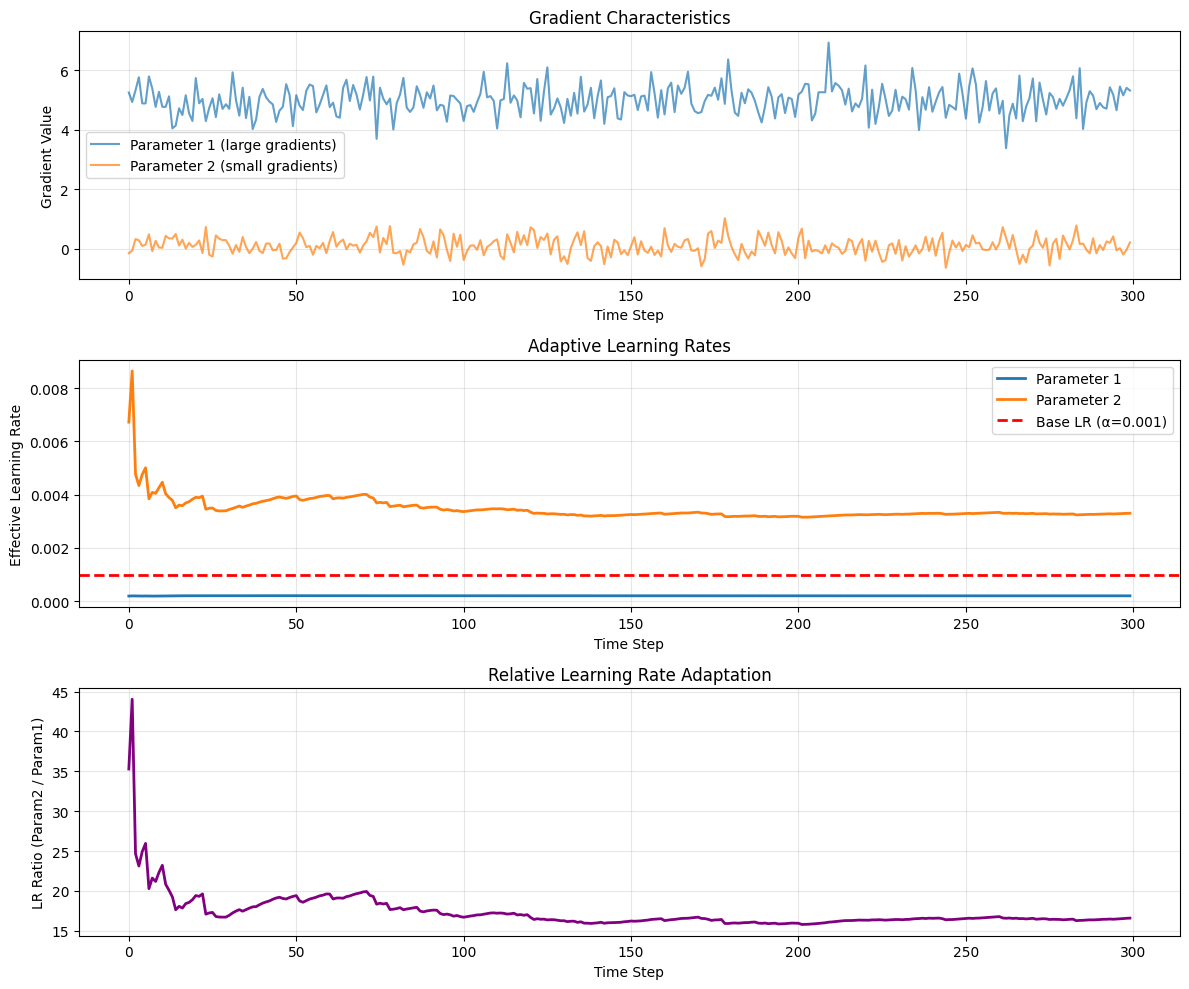

Parameter 1 (large gradients): Lower effective LR = 0.000200
Parameter 2 (small gradients): Higher effective LR = 0.003464

Adam automatically gives ~17.3x higher learning rate to parameter 2!


In [6]:
# Simulate two parameters with different gradient characteristics
np.random.seed(42)
steps = 300

# Parameter 1: Large, consistent gradients
grads_p1 = 5.0 + 0.5 * np.random.randn(steps)

# Parameter 2: Small, noisy gradients
grads_p2 = 0.1 + 0.3 * np.random.randn(steps)

# Track Adam's effective learning rate for each parameter
alpha = 0.001
beta1, beta2 = 0.9, 0.999
epsilon = 1e-8

m1, v1 = 0, 0
m2, v2 = 0, 0

eff_lr_p1 = []
eff_lr_p2 = []

for t in range(1, steps + 1):
    # Parameter 1
    m1 = beta1 * m1 + (1 - beta1) * grads_p1[t-1]
    v1 = beta2 * v1 + (1 - beta2) * (grads_p1[t-1] ** 2)
    v1_hat = v1 / (1 - beta2 ** t)
    eff_lr_p1.append(alpha / (np.sqrt(v1_hat) + epsilon))
    
    # Parameter 2
    m2 = beta1 * m2 + (1 - beta1) * grads_p2[t-1]
    v2 = beta2 * v2 + (1 - beta2) * (grads_p2[t-1] ** 2)
    v2_hat = v2 / (1 - beta2 ** t)
    eff_lr_p2.append(alpha / (np.sqrt(v2_hat) + epsilon))

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Gradients
ax1.plot(grads_p1, label='Parameter 1 (large gradients)', alpha=0.7, linewidth=1.5)
ax1.plot(grads_p2, label='Parameter 2 (small gradients)', alpha=0.7, linewidth=1.5)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Gradient Value')
ax1.set_title('Gradient Characteristics')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Effective learning rates
ax2.plot(eff_lr_p1, label='Parameter 1', linewidth=2)
ax2.plot(eff_lr_p2, label='Parameter 2', linewidth=2)
ax2.axhline(y=alpha, color='r', linestyle='--', label=f'Base LR (α={alpha})', linewidth=2)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Effective Learning Rate')
ax2.set_title('Adaptive Learning Rates')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Learning rate ratio
lr_ratio = np.array(eff_lr_p2) / np.array(eff_lr_p1)
ax3.plot(lr_ratio, linewidth=2, color='purple')
ax3.set_xlabel('Time Step')
ax3.set_ylabel('LR Ratio (Param2 / Param1)')
ax3.set_title('Relative Learning Rate Adaptation')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Parameter 1 (large gradients): Lower effective LR = {np.mean(eff_lr_p1):.6f}")
print(f"Parameter 2 (small gradients): Higher effective LR = {np.mean(eff_lr_p2):.6f}")
print(f"\nAdam automatically gives ~{np.mean(lr_ratio):.1f}x higher learning rate to parameter 2!")

## Comparing Optimizers on a 2D Function

Let's compare SGD and Adam on the Rosenbrock function to see how adaptive learning rates help.

In [7]:
# Define a simple 2D function to optimize (Rosenbrock function)
def rosenbrock(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2

def rosenbrock_grad(x, y):
    dx = -2 * (1 - x) - 400 * x * (y - x**2)
    dy = 200 * (y - x**2)
    return np.array([dx, dy])

# Optimization with SGD
def sgd_optimize(start, lr=0.001, steps=1000):
    path = [start.copy()]
    params = start.copy()
    
    for _ in range(steps):
        grad = rosenbrock_grad(params[0], params[1])
        params = params - lr * grad
        path.append(params.copy())
    
    return np.array(path)

# Optimization with Adam
def adam_optimize(start, lr=0.01, steps=1000):
    path = [start.copy()]
    params = start.copy()
    optimizer = AdamOptimizer(learning_rate=lr)
    
    for _ in range(steps):
        grad = rosenbrock_grad(params[0], params[1])
        params = optimizer.update(params, grad)
        path.append(params.copy())
    
    return np.array(path)

# Starting point
start_point = np.array([-1.0, 1.0])

# Run optimizers
sgd_path = sgd_optimize(start_point, lr=0.001, steps=1000)
adam_path = adam_optimize(start_point, lr=0.01, steps=1000)

print(f"SGD final position: [{sgd_path[-1][0]:.4f}, {sgd_path[-1][1]:.4f}]")
print(f"Adam final position: [{adam_path[-1][0]:.4f}, {adam_path[-1][1]:.4f}]")
print(f"Optimal position: [1.0, 1.0]")

SGD final position: [0.3636, 0.1292]
Adam final position: [0.9987, 0.9975]
Optimal position: [1.0, 1.0]


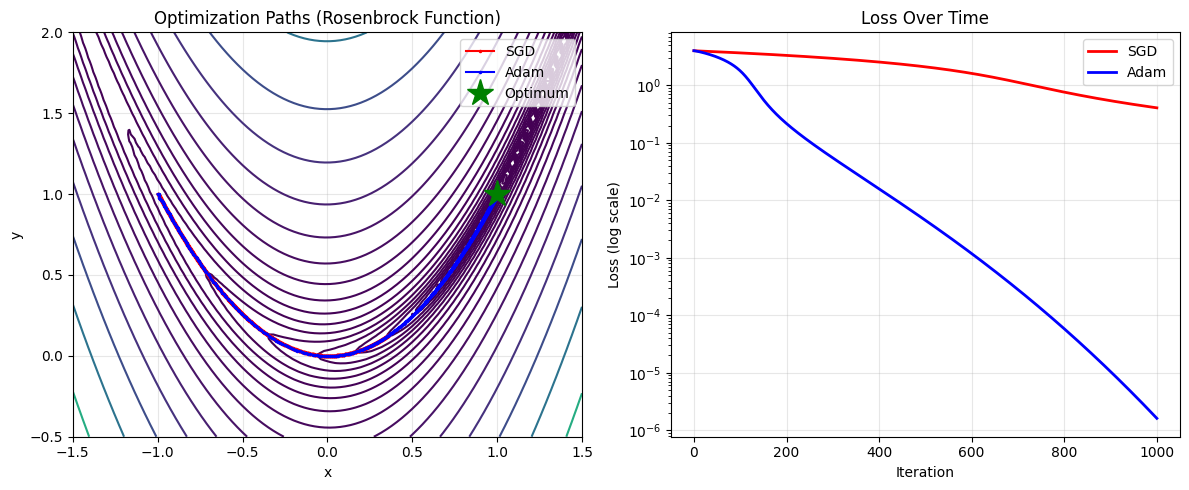

In [8]:
# Visualize the optimization paths
x = np.linspace(-1.5, 1.5, 100)
y = np.linspace(-0.5, 2.0, 100)
X, Y = np.meshgrid(x, y)
Z = rosenbrock(X, Y)

plt.figure(figsize=(12, 5))

# Contour plot
plt.subplot(1, 2, 1)
plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='viridis')
plt.plot(sgd_path[:, 0], sgd_path[:, 1], 'r.-', label='SGD', markersize=3, linewidth=1.5)
plt.plot(adam_path[:, 0], adam_path[:, 1], 'b.-', label='Adam', markersize=3, linewidth=1.5)
plt.plot(1, 1, 'g*', markersize=20, label='Optimum')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Optimization Paths (Rosenbrock Function)')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss over iterations
plt.subplot(1, 2, 2)
sgd_loss = [rosenbrock(p[0], p[1]) for p in sgd_path]
adam_loss = [rosenbrock(p[0], p[1]) for p in adam_path]
plt.semilogy(sgd_loss, 'r-', label='SGD', linewidth=2)
plt.semilogy(adam_loss, 'b-', label='Adam', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Properties of Adam

### 1. **Adaptive Learning Rates**
Each parameter gets its own learning rate based on gradient history:
- Parameters with large gradients → smaller effective learning rate
- Parameters with small gradients → larger effective learning rate

### 2. **Momentum from First Moment**
The first moment $m_t$ acts like momentum:
- Smooths out noisy gradients
- Accelerates learning in consistent directions
- Dampens oscillations

### 3. **Scale Invariance**
Adam is approximately scale-invariant to gradients:
- Works well even when different parameters have vastly different gradient scales
- Less sensitive to learning rate choice than SGD

### 4. **Bias Correction**
Critical for early training steps:
- Prevents underestimation of moments
- Allows aggressive learning in early iterations

## When to Use Adam

**Use Adam for:**
- Large datasets and high-dimensional parameter spaces
- Non-stationary objectives (changing data distributions)
- Problems with noisy or sparse gradients
- When you want a robust "default" optimizer
- NLP tasks and transformer models

**Consider alternatives when:**
- You need the absolute best generalization (SGD with momentum may generalize better)
- Memory is constrained (Adam stores two moment estimates per parameter)
- You have very specific domain knowledge about optimal learning rates

## Summary

The Adam optimizer combines:
1. **First moment** ($m$): Momentum-like behavior for gradient smoothing
2. **Second moment** ($v$): Adaptive learning rates based on gradient magnitude
3. **Bias correction**: Proper initialization handling
4. **Per-parameter adaptation**: Each weight gets its own effective learning rate

This makes Adam one of the most popular and effective optimizers for deep learning.